Идея заключается в том, что бы обучить нейросеть сначала на серии ударов, затем дообучить на ката и посмотреть, что получится. Экперимент дал неплохие результаты, однако, так как тестовая выборка и обучающая выборка это одни и те же движения снятые с разных ракурсов, об успехе говорить рано. Для более точной оценки, необходимо больше независимых видео с ката.

Так как других видео с ката пока нет, все внимание сосредоточил на подбор оптимальной архитектуры некйросети для обучения на серии ударов.

Во время обучения нейросети на серии ударов былы исправлены некоторые ошибки и добавлены новые фишки. Этот ноутбук частично устарел, но в дальнейшем, некоторые участки кода для обучения на ката можно будет взять отсюда

#Начальные установки и загрузка

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import random

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,TimeDistributed,Reshape, Dropout
from keras.utils import Sequence
from keras.models import load_model
from keras.metrics import Accuracy, Precision, Recall, F1Score

import gc

from scipy import interpolate
import seaborn as sns
from sklearn import metrics


In [ ]:
ModelSavePath='/content/drive/MyDrive/internship/karate/models' #Путь к папке  с сохраненными моделями
NetName='2Conv' #Имя модели
win_len=100 #Ширина окна (количество кадро, которое будем одновременно подавать в сеть)
step=3 #шаг сдвига окна при обучении
batch_size=32
speed_ratios=[1,2] #[1,2,4,8] # коэфициенты имитации замедления видео для обучения
smooth_win=10  #Ширина окна сглаживания (если <2 сглаживание не производдится)
add_speed=True #добавлять в данные колонки с первой производной
discret_speed=True
discret_speed_threshold= 5

##Словари

In [ ]:
#Симметричные углы
symmetrical_angles= [
 ('a12_14_16','a11_13_15'),   #угол в  локтевом суставе
 ('a14_12_24','a13_11_23'),   #угол в  плечевом суставе (вертикально)
 ('a14_12_11','a13_11_12'),   #угол в  плечевом суставе (горизонтально)
 ('a24_26_28','a23_25_27'),   #угол в  коленном суставе
 ('a12_24_26','a11_23_25'),   #угол в  тазобедренном суставе
 ('a25_27_31','a26_28_32'),   #угол в  стопе
 ('a23_11_7','a24_12_8'),     #угол между линиями бедро-плечо-ухо

 #('o12_14_OY','o11_13_OY'),   #угол между линия плечо-локоть руки и OY
 #('o12_14_OX','o11_13_OX'),   #угол между линия плечо-локоть руки и OX
 #('o12_14_OZ','o11_13_OZ'),   #угол между линия плечо-локоть руки и OZ

 #('o14_16_OY','o13_15_OY'),   #угол между линия локоть-запястье руки и OY
 #('o14_16_OX','o13_15_OX'),   #угол между линия локоть-запястье руки и OX
 #('o14_16_OZ','o13_15_OZ'),   #угол между линия локоть-запястье руки и OZ

 #('o24_26_OY','o23_25_OY'),   #угол между линия бедро-колено ног и OY
 #('o24_26_OX','o23_25_OX'),   #угол между линия бедро-колено ног и OX
 #('o24_26_OZ','o23_25_OZ'),   #угол между линия бедро-колено ног и OZ

 #('o26_28_OY','o25_27_OY'),   #угол между линия колено-щиколотка ноги и OY
 #('o26_28_OX','o25_27_OX'),   #угол между линия колено-щиколотка ноги и OX
 #('o26_28_OZ','o25_27_OZ'),   #угол между линия колено-щиколотка ноги и OZ
]

In [ ]:
class_dic={
    0: 'GEDAN BARAI',
    1: 'GYAKU DZUKI',
    2: 'KIDZAMI DZUKI',
    3: 'MAWASHI DZUKI',
    4: 'MAWASHI GERI',
    5: 'MAI GERI KEAGE',
    6: 'SOTO UKE',
    7: 'URA MAWASHI GERI',
    8: 'URAKEN UCHI',
    9: 'UCHI UKE',
    10: 'OI ZUKI (No in Dataset)',
    11: 'AGE UKE (No in Dataset)',
    12: 'STANCE',
    13: 'OTHER'
    }

##Загрузка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Грузим основной датасет
data_path = '/content/drive/MyDrive/internship/karate/dataset_alia/CSV'
filename = 'dataset__all_features_phase.csv'
df = pd.read_csv(os.path.join(data_path,filename)) #Основной датасет
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,0,...,0.839532,0.539682,-0.062687,0.746729,-0.545266,0.380895,0.805452,-0.073288,0.588113,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0.829084,0.549687,-0.102292,0.756509,-0.525787,0.388899,0.803362,-0.068162,0.591577,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0.826367,0.553103,-0.105799,0.763141,-0.515636,0.389532,0.804396,-0.064436,0.590588,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0.823055,0.551126,-0.137264,0.764354,-0.504475,0.401582,0.797728,-0.061704,0.599852,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0.825035,0.549418,-0.132121,0.766788,-0.502895,0.398914,0.799612,-0.060594,0.597452,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284636,0,0,0,0,0,0,0,0,0,0,...,0.906085,0.364353,-0.215073,0.894297,-0.337195,0.294164,0.793764,0.577821,0.189900,1.0
284637,0,0,0,0,0,0,0,0,0,0,...,0.906407,0.366269,-0.210411,0.891249,-0.348732,0.289934,0.802920,0.567092,0.183646,1.0
284638,0,0,0,0,0,0,0,0,0,0,...,0.904525,0.371435,-0.209451,0.890072,-0.356947,0.283480,0.806687,0.563872,0.176929,1.0
284639,0,0,0,0,0,0,0,0,0,0,...,0.903095,0.380851,-0.198425,0.885717,-0.362682,0.289772,0.811039,0.558422,0.174299,1.0


#Подготовка датафрейма

In [ ]:
#Оставим только размеченные данные
df=df[df['phase']>0]
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,0,...,0.839532,0.539682,-0.062687,0.746729,-0.545266,0.380895,0.805452,-0.073288,0.588113,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0.829084,0.549687,-0.102292,0.756509,-0.525787,0.388899,0.803362,-0.068162,0.591577,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0.826367,0.553103,-0.105799,0.763141,-0.515636,0.389532,0.804396,-0.064436,0.590588,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0.823055,0.551126,-0.137264,0.764354,-0.504475,0.401582,0.797728,-0.061704,0.599852,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0.825035,0.549418,-0.132121,0.766788,-0.502895,0.398914,0.799612,-0.060594,0.597452,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284636,0,0,0,0,0,0,0,0,0,0,...,0.906085,0.364353,-0.215073,0.894297,-0.337195,0.294164,0.793764,0.577821,0.189900,1.0
284637,0,0,0,0,0,0,0,0,0,0,...,0.906407,0.366269,-0.210411,0.891249,-0.348732,0.289934,0.802920,0.567092,0.183646,1.0
284638,0,0,0,0,0,0,0,0,0,0,...,0.904525,0.371435,-0.209451,0.890072,-0.356947,0.283480,0.806687,0.563872,0.176929,1.0
284639,0,0,0,0,0,0,0,0,0,0,...,0.903095,0.380851,-0.198425,0.885717,-0.362682,0.289772,0.811039,0.558422,0.174299,1.0


##Выбор признаков, которые будем подавать в сеть

In [ ]:
#сформируем список с названиями колонок для X и Y
column_list=list(df)
x_column_list=[x for x in column_list if (x.startswith(('a','g','o')) and  '_OZ' not in x and '_OX' not in x and  '_OY' not in x)] #в X  только данные о  cos углов (их имена начинаются на 'a','g','o')
y_column_list=[x for x in column_list if x.isdigit()] # толлько метки
print(f'В X войдут следующие колонки: {x_column_list}')
print(f'В Y войдут следующие колонки: {y_column_list}')

В X войдут следующие колонки: ['a12_14_16', 'a11_13_15', 'a14_12_24', 'a13_11_23', 'a14_12_11', 'a13_11_12', 'a24_26_28', 'a23_25_27', 'a12_24_26', 'a11_23_25', 'a25_27_31', 'a26_28_32', 'a23_11_7', 'a24_12_8', 'g12_11_28_27', 'g12_11_24_23', 'g12_11_26_25', 'g12_11_14_13', 'g12_11_16_15', 'g14_16_13_15', 'g12_14_11_13', 'g24_26_23_25', 'g26_28_25_27']
В Y войдут следующие колонки: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']


In [ ]:
#сформируем окончательный список  колонок, которые нам могут понадобится остальные удалим для экономии памяти
need_column_list=[ 'correct', 'main_folder', 'folder', 'filename', 'frame#', 'folder_cat', 'correct_cat', 'filename_cat', 'phase'] #Служебные колонки
vizual_column_list=[x for x in column_list if x.startswith(('x_','y_'))] # для визуализации
need_column_list.extend(y_column_list)
need_column_list.extend(x_column_list)
need_column_list.extend(vizual_column_list)
df=df[need_column_list]
df

,correct,main_folder,folder,filename,frame#,folder_cat,correct_cat,filename_cat,phase,0,...,x_28,y_28,x_29,y_29,x_30,y_30,x_31,y_31,x_32,y_32
0,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),0,0,0,0,1.0,0,...,0.331218,0.859000,0.472340,0.841459,0.318306,0.875136,0.520081,0.855820,0.350605,0.909742
1,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),1,0,0,0,1.0,0,...,0.331274,0.861117,0.472208,0.842373,0.317856,0.876080,0.519879,0.854984,0.350485,0.909176
2,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),2,0,0,0,1.0,0,...,0.331360,0.862314,0.472195,0.843167,0.317757,0.876620,0.519846,0.854440,0.350192,0.909110
3,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),3,0,0,0,1.0,0,...,0.331413,0.862243,0.472126,0.844075,0.317735,0.876399,0.520018,0.853493,0.348890,0.909107
4,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),4,0,0,0,1.0,0,...,0.331412,0.862217,0.471966,0.844548,0.317402,0.876261,0.520159,0.852752,0.348577,0.909360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284636,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,533,0,1,479,1.0,0,...,0.425017,0.833655,0.608160,0.861945,0.430866,0.854375,0.601156,0.894158,0.393433,0.863834
284637,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,534,0,1,479,1.0,0,...,0.426847,0.833515,0.608155,0.861851,0.431666,0.854004,0.601365,0.893943,0.395236,0.863627
284638,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,535,0,1,479,1.0,0,...,0.427801,0.833233,0.608153,0.861681,0.432111,0.853741,0.601633,0.893903,0.397387,0.863331
284639,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,536,0,1,479,1.0,0,...,0.427978,0.832918,0.607926,0.861201,0.432132,0.853586,0.602015,0.893069,0.397073,0.863105


##Зеркалирование данных

In [ ]:
def add_mirror (df):
  df_mir=df.copy()
  df_mir['filename']=df_mir['filename'].apply(lambda x: x+'_mirror')
  for pair in symmetrical_angles:
    temp = df_mir[pair[0]]
    df_mir[pair[0]] = df_mir[pair[1]]
    df_mir[pair[1]] = temp
  df=pd.concat([df,df_mir],ignore_index=True)
  return df

In [ ]:
df= add_mirror (df)

In [ ]:
df

,correct,main_folder,folder,filename,frame#,folder_cat,correct_cat,filename_cat,phase,0,...,x_28,y_28,x_29,y_29,x_30,y_30,x_31,y_31,x_32,y_32
0,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),0,0,0,0,1.0,0,...,0.331218,0.859000,0.472340,0.841459,0.318306,0.875136,0.520081,0.855820,0.350605,0.909742
1,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),1,0,0,0,1.0,0,...,0.331274,0.861117,0.472208,0.842373,0.317856,0.876080,0.519879,0.854984,0.350485,0.909176
2,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),2,0,0,0,1.0,0,...,0.331360,0.862314,0.472195,0.843167,0.317757,0.876620,0.519846,0.854440,0.350192,0.909110
3,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),3,0,0,0,1.0,0,...,0.331413,0.862243,0.472126,0.844075,0.317735,0.876399,0.520018,0.853493,0.348890,0.909107
4,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),4,0,0,0,1.0,0,...,0.331412,0.862217,0.471966,0.844548,0.317402,0.876261,0.520159,0.852752,0.348577,0.909360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569277,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,533,0,1,479,1.0,0,...,0.425017,0.833655,0.608160,0.861945,0.430866,0.854375,0.601156,0.894158,0.393433,0.863834
569278,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,534,0,1,479,1.0,0,...,0.426847,0.833515,0.608155,0.861851,0.431666,0.854004,0.601365,0.893943,0.395236,0.863627
569279,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,535,0,1,479,1.0,0,...,0.427801,0.833233,0.608153,0.861681,0.432111,0.853741,0.601633,0.893903,0.397387,0.863331
569280,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,536,0,1,479,1.0,0,...,0.427978,0.832918,0.607926,0.861201,0.432132,0.853586,0.602015,0.893069,0.397073,0.863105


In [ ]:
#del df_mir
gc.collect()

49

##Разделение на тренеровочную и проверочную выборки

In [ ]:
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df['main_folder'])
kick_list

array(['ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'КИДЗАМИ ДЗУКИ (ПРЯМОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'МАВАШИ  ДЗУКИ (КРУГОВОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'МАВАШИ ГЕРИ  (КРУГОВОЙ УДАР ЗАДНЕЙ НОГОЙ)',
       'МАЙ ГЕРИ КЕАГЕ (ПРЯМОЙ УДАР ЗАДНЕЙ НОГОЙ)',
       'СОТО УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'УРА МАВАШИ ГЕРИ (ОБРАТНЫЙ КРУГОВОЙ  УДАР ЗАДНЕЙ НОГОЙ)',
       'УРАКЕН УЧИ (КРУГОВОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)'], dtype=object)

In [ ]:
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df.loc[df['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  total_file_list.extend(file_list)


для удара ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ) размечены файлы ['Андрей ГЕДАН БАРАЙ' 'Андрей ГЕДАН БАРАЙ (2)'
 'Андрей ГЕДАН БАРАЙ (2)_flip' 'Андрей ГЕДАН БАРАЙ (2)_flip_mirror'
 'Андрей ГЕДАН БАРАЙ (2)_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_flip'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_flip_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_flip'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_flip_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_mirror'
 'Андрей ГЕДАН БАРАЙ_flip' 'Андрей ГЕДАН БАРАЙ_flip_mirror'
 'Андрей ГЕДАН БАРАЙ_mirror'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_flip'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_flip_mirror'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_mirror'
 'Ан

Будет не правильным, если тренировать сеть и валидировать результаты мы будем на данных из одних и тех же файлов. Поэтому, проверять качество обучения будем на тех видеофайлах, которые сеть не видела.

Поэтому, в проверочную вборку будем выбирать не фрагменты с видео, а полностью файлы.

In [ ]:
random.seed(42)
val_files_count=len(total_file_list)//5 #20%
val_files=np.random.choice(total_file_list,size=val_files_count,replace=False)
print(f'Для Валидационной выборки выбрано {val_files_count} файлов из {len(total_file_list)}')
val_files=sorted(val_files)
for vf in val_files:
  print(vf)

Для Валидационной выборки выбрано 192 файлов из 960
Андрей ГЕДАН БАРАЙ
Андрей ГЕДАН БАРАЙ (2)_flip_mirror
Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)
Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)
Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_flip_mirror
Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_mirror
Андрей ГЕДАНБАРАЙ (кулак развернут не верно 2)_flip
Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)_flip
Андрей ГЬЯКУ ДЗУКИ (2)_flip
Андрей ГЬЯКУ ДЗУКИ (без поворота корпуса 2)_flip_mirror
Андрей ГЬЯКУ ДЗУКИ (выпирают пальцы 1)_mirror
Андрей ГЬЯКУ ДЗУКИ_flip
Андрей КИДЗАМИ ДЗУКИ (кулак 2)
Андрей КИДЗАМИ ДЗУКИ (кулак)_mirror
Андрей КИДЗАМИ ДЗУКИ (локоть 1)_flip_mirror
Андрей КИДЗАМИ ДЗУКИ_mirror
Андрей МАВАШИ ГЕРИ (без какае коми 1)_flip_mirror
Андрей МАВАШИ ГЕРИ_flip
Андрей МАВАШИ ДЗУКИ (2)_flip_mirror
Андрей МАВАШИ ДЗУКИ (наклон головы вниз 1)
Андрей МАВАШИ ДЗУКИ (наклон головы вниз 2)_flip
Андрей МАВАШИ ДЗУКИ (удар прямой рукой  1)_flip
Андрей МАВАШИ 

In [ ]:
#Установим поле filename в качестве индекса датафрейма для увеличения скорости обработки
df=df.set_index(['filename'],drop=False)

In [ ]:
#Формируем тренеровочную и валидационную выборки
df_train=df.loc[~df.index.isin(val_files)]
df_val=df.loc[df.index.isin(val_files)]

print (f'В трененровочной выборке {len(np.unique(df_train["filename"]))} файлов')
print (f'В проверочной выборке {len(np.unique(df_val["filename"]))} файлов')

print (f'В трененровочной выборке {len(df_train)} записей')
print (f'В проверочной выборке {len(df_val)} записей')

В трененровочной выборке 768 файлов
В проверочной выборке 192 файлов
В трененровочной выборке 454684 записей
В проверочной выборке 114598 записей


#Основные функции

##Аугментация

In [ ]:
def aug_random_shift (X,Y,shift_max=1,p=0.5):
  '''
  выполняет случайный сдвиг колонок на случайную величину shift вверх или вниз

  X - ndarray  2D входные данные
  Y - ndarray  2D выходные данные
  shift - максимальная величина сдвига
  p  - вероятность применения трансформации

  return -  новые X и Y ndarray со сдвигами . Количество строк (кадров) в которых меньше чем в изначальных данных на 2*shift
  '''
  def get_random_slice(column, win_len, shift_max=1):
    '''
    возвращает случайный срез данных для одной колонки длиной win_len
    '''
    shift=np.random.randint(-1*shift_max,shift_max+1)
    start_index=(len(column)-win_len)//2 + shift

    return column[start_index:start_index+win_len]

  win_len=len(X)-shift_max*2  # Количество кадров, которое мы должны вернуть
  p_trans=random.random()
  if p_trans>p:
    return X[shift_max:shift_max+win_len],Y[shift_max:shift_max+win_len] # не применяем трансформацию
  x= np.apply_along_axis(get_random_slice, axis=0, arr=X, win_len=win_len, shift_max=shift_max)
  y=Y[shift_max:shift_max+win_len]
  return x,y

In [ ]:
def get_slow_motion(column, ratio):
  '''
  Выполняет интерполяцию данных column и возращает последовательность в ratio раз длиннее исходного
  '''
  x=range(0,len(column))
  inter = interpolate.interp1d(x, column,kind="linear")
  x_inter=np.linspace(0,len(column)-1,num=len(column)*ratio)
  y_inter = inter(x_inter)
  return y_inter

In [ ]:
def aug_speed_long(X,Y=None,ratio=1):
  '''
  получает на вход набор углов,  имитирует случайное замедление в ratio раз, возвращает все получившиеся данные
  '''
  if ratio==1:
    return X,Y #  не уменьшаем скорость
  X=np.apply_along_axis(get_slow_motion, axis=0, arr=X,ratio=ratio)
  if Y is not None:
    Y=np.repeat(Y, ratio,axis=0)
  return X,Y


In [ ]:
#Для аугментации в датагенераторе
def aug_speed(X,Y=None,speed_ratios=[1,2,4,8],p=1):
  '''
  получает на вход набор углов,  имитирует случайное замедление в ratio раз, из получившейся последовательности возвращает случайный участок такой же длины, как и входные данные
  p  - вероятность применения трансформации
  '''
  p_trans=random.random()
  if p_trans>p:
    return X,Y # не применяем трансформацию
  ratio_index=np.random.randint(0,len(speed_ratios))
  ratio_value=speed_ratios[ratio_index]
  if ratio_value==1:
    return X,Y # не уменьшаем скорость
  result=np.apply_along_axis(get_slow_motion, axis=0, arr=X,ratio=ratio_value)
  #Получили массив в ratio раз длиннее, но мы должны вернуть данные той же размерности. Выберем случайный участок нужной длины
  source_len=len(X)
  result_len=len(result)
  begin_index=np.random.randint(0,result_len-source_len)
  X= result[begin_index:begin_index+source_len]
  if Y is not None:
    Y=np.repeat(Y, ratio_value,axis=0)
    Y=Y[begin_index:begin_index+source_len]
  return X,Y


In [ ]:
# Функция  применения скользящего окна для сглаживания 1D (1 последовательность)
def aug_smooth_column(data, window_width):
    smoothed_data = np.convolve(data, np.ones(window_width) / window_width, mode='same')
    return smoothed_data

In [ ]:
# Функция  применения скользящего окна для сглаживания 2D (несколько последовательностей)
def aug_smooth(data, window_width):
    if window_width<2:
      return data
    smoothed_data=np.apply_along_axis(aug_smooth_column, axis=0, arr=data,window_width=window_width)
    return smoothed_data

In [ ]:
#Добавление столбцов с первой производной
def aug_add_speed_data (X, discret_speed, discret_speed_threshold):
  '''
  добавляет к исходному тензору столбцы с первыми производными. Для нулевой строки первая производная =0
  discret_speed - Если True, то в качестве скоростей дискретные  значения -1;0;1
  discret_speed_threshold - % от разницы между максимальной и минимальной скоростями, в пределах которого скорость будет считаться 0
  '''
  x_d=np.diff(X,n=1,axis=0) #Получили скорости
  x_d=np.vstack([np.zeros(x_d.shape[-1]),x_d]) #Первая строка для скоростей 0

  if discret_speed:
  #Попробуем указывать направление скоростей, а не их значения
    min=np.min(np.abs(x_d))
    max=np.max(np.abs(x_d))
    threshoold = min+(max-min)/100*discret_speed_threshold

    x_d[(x_d<=threshoold) & (x_d>=-threshoold)]=0 #Для значений по модулю меньше threshoold  считаем что скорость =0
    x_d[x_d>threshoold]=1
    x_d[x_d<-threshoold]=-1
  x_res=np.hstack([X,x_d])
  return x_res

##Подготовка датасета

In [ ]:
def prepare_data(X,Y=None,speed_ratio=1,smooth_win=0,add_speed=True):
  '''
  Выполняет необходимые X и Y перед подачей в сеть
  '''
  X=np.arccos(X)/np.pi #переведем сразу в радианы и разделим на PI (номировка 0-1)
  X,Y=aug_speed(X,Y,speed_ratios=[speed_ratio],p=1) # Возвращаем замедленный в ratio раз фрагмент такой же длины
  #X,Y = aug_speed_long(X,Y,speed_ratio) # Возвращаем замедленный в ratio раз фрагмент
  X=aug_smooth(X,smooth_win) #Сглаживание данных
  if add_speed:
    X=aug_add_speed_data(X,discret_speed=discret_speed,discret_speed_threshold=discret_speed_threshold) #Добавили колонки со скоростями (первая производная)
  return X,Y

In [ ]:
def get_X_Y(df,x_columns,y_columns,speed_ratios=[1,2,4,8],smooth_win=0,add_speed=True):
  '''
  Формирует списки ndarray для входных и выходных данных для обучения. Выполняет предварительную подготовку данных.
  Каждый элемент списка представляет собой данные для одного файла
  df - с данными
  x_columns - колонки, которые войдут в X
  y_columns - колонки, которые войдут в Y

  return
  списки X и Y в виде ndarray
  '''

  file_names=np.unique(df['filename'])
  X=[]
  Y=[]
  for speed_ratio in speed_ratios:
    for file_index, file_name in  enumerate(file_names):
        file_data=df[df['filename']==file_name].sort_values('frame#')
        #Получаем данные для X и Y
        x_data=file_data[x_columns].values
        y_data=file_data[y_columns].values
        #Перобразуем данные
        x_data,y_data=prepare_data(x_data,y_data,speed_ratio,smooth_win,add_speed)
        #Добавляем в списки
        X.append(x_data)
        Y.append(y_data)
  print (f'Конечная длина списка X {len(X)}  длина списка Y {len(Y)}')
  return X,Y


##ДатаГенератор

###Класс ДатаГенератора

In [ ]:
class TimeSeriesGenerator(Sequence):
    def __init__(
        self,
        X,           # список ndarray  Входные данные. Каждый элемент списка представляет собой данные для одного файла
        Y,           # список ndarray  Выходные данные Каждый элемент списка представляет собой данные для одного файла
        win_len,     # Длина последовательности, которую мы будем использовать в каждом батче (окно).
        batch_size,  # Размер батча.
        step=1,      # Шаг, на который сдвигается окно при генерации последовательностей.
        shift_p=0.1,  # Вероятность применения аугментации сдвига фаз
        shift_max=1,  # Максимальный сдвиг фазы
                 ):
        """
        Реализует датагенератор

        Параметры:
        - X - список ndarray  Входные данные. Каждый элемент списка представляет собой данные для одного файла
        - Y - список ndarray  Выходные данные Каждый элемент списка представляет собой данные для одного файла
        - win_len: Длина последовательности, которую мы будем использовать в каждом батче (окно).
        - batch_size: Размер батча.
        - step: Шаг, на который сдвигается окно при генерации последовательностей.
        - shift_p    Вероятность применения аугментации сдвига фаз
        - shift_max    Максимальный сдвиг фазы
        """
        self.X =X
        self.Y=Y
        self.win_len = win_len + 2*shift_max
        self.batch_size = batch_size
        self.step = step
        self.shift_p = shift_p
        self.shift_max = shift_max
        self.indices = self._generate_indices()

    def _generate_indices(self):
        """
        Генерация индексов для выбора случайных последовательностей из временных рядов.

        Returns:
        - indices: Список кортежей (индекс файла в списке X, начальный индекс ).
        """
        indices = []
        for file_index, file_data  in  enumerate(self.X):
          current_len=len(indices)
          for start_index in range(0, len(file_data) - self.win_len + 1, self.step):
            indices.append((file_index, start_index))
          #print(f'Для файла с индексом {file_index} добавлено {len(indices) - current_len} фрагментов')
        print(f'Всего Сформировано {len(indices)} фрагментов')
        return indices

    def __len__(self):
        """
        Возвращает количество батчей в генераторе.

        Returns:
        - Количество батчей.
        """
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        """
        Получение батча данных по индексу.

        Parameters:
        - index: Индекс батча.

        Returns:
        - X_batch: Входные данные батча.
        - y_batch: Выходные данные батча.
        """
        #Выбираем индексы из которых будем формировать батч
        batch_indices = np.random.choice(len(self.indices), size=self.batch_size, replace=False) #Выбрали batch_size индексов в self.indices
        batch_indices = [self.indices[i] for i in batch_indices] #Выбрали значения по индексам

        X_batch = []
        Y_batch = []

        for file_index, start_index in batch_indices:
            end_index = start_index + self.win_len
            file_data_x=self.X[file_index]
            file_data_y=self.Y[file_index]
            x_data=file_data_x[start_index:end_index]
            y_data=file_data_y[start_index:end_index]

            #Аугментация
            x_data,y_data =aug_random_shift(x_data,y_data,self.shift_max,self.shift_p) #Случайный сдвиг фаз

            X_batch.append(x_data)
            Y_batch.append(y_data)

        return np.array(X_batch), np.array(Y_batch)


##Отображение графиков обучения и Confusion Matrix

In [ ]:
def show_charts(history,figsize=(25,8), title=None):
  '''Показывает графики истории обучения
  history - словарь из объекта history
  '''
  if history is None or len(history)==0:
    print ('Данные об истории обучения отсутствуют')
    return
  plt.figure(figsize=figsize)
  #график ошибки
  ax=plt.subplot(1,2,1)
  plt.plot(history['loss'],
         label='Ошибка на обучающем наборе')
  plt.plot(history['val_loss'],
         label='Ошибка на проверочном наборе')
  plt.legend()# Отрисовка легенды
  plt.title(title)
  ax.grid()
  plt.xlabel('Эпоха обучения')

  #графики метрик
  ax=plt.subplot(1,2,2)
  keys=list(history.keys())
  keys.remove('loss')
  keys.remove('val_loss')

  for item in keys:
    lable='тренеровочном'
    if item.startswith('val_'):
        lable='проверочном'
    plt.plot(history[item],
         label=f'Доля верных ответов на {lable} наборе {item}')
  # Отрисовка подписей осей
  plt.xlabel('Эпоха обучения')
  plt.title(title)
  ax.grid()
  plt.legend()# Отрисовка легенды
  plt.show()

In [ ]:
def show_confusion_matrix(Y_test,result):
  figsize = (8,8)
  fig, ax = plt.subplots(figsize=figsize)
  plt.title('Confusion Matrix')
  actual_classes=np.unique([np.argmax(Y_test,axis=1),np.argmax(result,axis=1)])
  tick_labels=[class_dic[cl] for cl in class_dic if cl in actual_classes]
  cm = metrics.confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(result,axis=1),normalize=None)
  hmap=sns.heatmap(cm, annot=True, fmt='.0f', cbar=False,
                    xticklabels=tick_labels,
                    yticklabels=tick_labels)
  plt.ylabel('Real')
  plt.xlabel('Predicted')
  plt.show()

##Генерация видео

In [ ]:
def draw_landmarks(data,frame):
  '''
  проецирует landmarks на видео

  data - DataFrame  с  координатами точек соответствующими  текущему кадру
  frame - изображение

  '''
  def calc_coordinate (data,frame,dot):
    '''
    Считает реальные ккординаты точки
    data - Serias с координатfми точек для каждого кадра
    frame - изображение
    dot  - номер точки
    '''
    x=int(data['x_'+dot].iloc[0]*frame.shape[1])
    y=int(data['y_'+dot].iloc[0]*frame.shape[0])
    return (x,y)

  def draw_line (data,frame,dot1,dot2,color=(0, 255, 0)):
    #print(f'{calc_coordinate(data,frame,dot1)} --- {calc_coordinate(data,frame,dot2)}')
    cv2.line(frame, calc_coordinate(data,frame,dot1), calc_coordinate(data,frame,dot2), color, thickness=2)
    return frame


  #тело
  frame=draw_line(data,frame,'11','12',(0, 255, 0))
  frame=draw_line(data,frame,'12','24',(0, 255, 0))
  frame=draw_line(data,frame,'24','23',(0, 255, 0))
  frame=draw_line(data,frame,'23','11',(0, 255, 0))

  #ноги
  frame=draw_line(data,frame,'23','25',(255, 255, 0))
  frame=draw_line(data,frame,'25','27',(255, 255, 0))

  frame=draw_line(data,frame,'24','26',(255, 0, 255))
  frame=draw_line(data,frame,'26','28',(255, 0, 255))

  #руки
  frame=draw_line(data,frame,'11','13',(255, 255,0))
  frame=draw_line(data,frame,'13','15',(255, 255, 0))

  frame=draw_line(data,frame,'12','14',(255, 0, 255))
  frame=draw_line(data,frame,'14','16',(255, 0, 255))
  return frame

In [ ]:
def get_dot_coord (df,dot):
  x=f'{df["x_"+str(dot)].iloc[0]:.2f}'
  y=f'{df["y_"+str(dot)].iloc[0]:.2f}'
  z=f'{df["z_"+str(dot)].iloc[0]:.2f}'
  v=f'{df["v_"+str(dot)].iloc[0]:.0f}'
  return (x,y,z,v)

def get_angle_dots(angle):
  '''
  Возвращает список точек по названию угла
  '''
  dots=angle[1:].split('_')
  return dots

def get_angle_dots_coord (df,angle):
  '''
  Возвращает строковое представление значений коодинат для точек одного угла
  '''
  dots=get_angle_dots(angle)
  Data=[]
  for dot in dots:
    if dot=='':
      continue
    koord=get_dot_coord(df,dot)
    Data.append(koord)
  return tuple(Data)

In [ ]:
DisplaySkipFrame=10

def mark_move(data,VideoPathIn, VideoPathOut,Y_data=None,frame_ratio=1,original_df=None,show_landmarks=None,drop_frame_count=0):
  '''
  маркирует каждый кадр из видео VideoPathIn, в соответствии с данными data.  Формирует новое видео  по VideoPathOut
  data - numpy массив с результатами обработки  сетью (количество кадров,количество классов)
  VideoPathIn - путь к исходному видеофайлу
  VideoPathIn - путь к итоговому видеофайлу
  Y_data - numpy массив с правильными результатами (количество кадров,количество классов)
  frame_ratio - обрабатывать каждый frame_ratio кадр (пропуск кадров) Нужно если хотим имитировать замедление видео

  drop_frame_count - сколько кадров нужно пропустить, нужно если предикт был не с 0го кадра
  '''
  cap = cv2.VideoCapture(VideoPathIn)
  if (cap.isOpened() == False):
    print("Ошибка открытия видеофайла")
    return
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print (f'Всего кадров {total_frame_count}')
  frame_size=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #print (frame_size)
  Output = cv2.VideoWriter(VideoPathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)
  FrameIndex=-1
  while(True): # Вывод кадров производится  в цикле
    ret, frame = cap.read()
    FrameIndex+=1
    if FrameIndex<drop_frame_count:
      continue
    FrameRatioIndex=(FrameIndex-drop_frame_count)//frame_ratio #Счетчик кадров с учетом frame_ratio
    #print(f'{FrameIndex} , {FrameRatioIndex}')
    if total_frame_count<=FrameIndex or len(data)<=FrameRatioIndex:
      break;
    if not ret: #кадр не вернулся по какой то причине
      continue
    if FrameIndex%frame_ratio!=0:
      continue
    kick_code=np.argmax(data[FrameRatioIndex])
    cv2.putText(frame, f'Predict: {class_dic[kick_code]}', (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4)
    cv2.putText(frame, f'frame:{FrameIndex}', (10,210), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4)
    cv2.putText(frame, f'val:{max(data[FrameRatioIndex]):.4f}', (10,280), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4)
    if Y_data is not None:
      kick_code=np.argmax(Y_data[FrameRatioIndex])
      cv2.putText(frame, f'Real: {class_dic[kick_code]}', (10,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4)

    if show_landmarks and original_df is not None:
      koord_data=original_df[original_df['frame#']==FrameIndex]
      draw_landmarks(koord_data,frame)

      '''
      #вывод значений углов
      angle='a11_23_25'
      L_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} LEFT TAZ: {L_angle:.1f}', (10,350), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,410), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)

      angle='a23_25_27'
      L_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} LEFT KOLENO: {L_angle:.1f}', (10,470), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,530), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)

      angle='a12_24_26'
      R_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} RIGHT TAZ: {R_angle:.1f}', (10,590), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,640), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)

      angle='a24_26_28'
      R_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} RIGHT KOLENO: {R_angle:.1f}', (10,700), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,760), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)
      '''


      #вывод кадров на экран (для отладки, потом убрать)
    if FrameIndex%DisplaySkipFrame==0: #Начиная с первого кадра каждой секунды
      clear_output(wait=True)
      min_frame =cv2.resize(frame, (int(frame.shape[1]/5),int(frame.shape[0]/5)))
      cv2_imshow(min_frame)
      print (f'Обработано {FrameIndex} кадров')

    Output.write(frame)
  Output.release()
  cap.release()
  cv2.destroyAllWindows()
  print (f'Всего обработано {FrameIndex} кадров')

##Предикт

In [ ]:
def predict(model,df,x_columns):
  '''
  Вычисляет удар  для каждого кадра

  Параметры:
  model - Модель
  df  - датафрейм с данными для одного видео
  x_columns - список колонок,котрые будут выступать в качестве X

  Возвращает результат обработки данных сетью (numpy массив с классификацией удара в каждом кадре)
  '''
  x_data=df[x_columns].values #Получили np массив
  #print(f'На входе:{x_data.shape}')
  x_data,_=prepare_data(x_data,Y=None,speed_ratio=1,smooth_win=smooth_win,add_speed=add_speed)
  #print(f'На выходе:{x_data.shape}')

  frame_count=len(x_data)
  if frame_count<win_len:
    #очень короткий ролик, добъем до необходимой длины последним кадром
    last_frame=x_data[-1:]
    last_frames=np.tile(last_frame,win_len-frame_count)
    x_data=np.concatenate((x_data, last_frames), axis=0)
    res=np.squeeze(model(np.expand_dims(x_data, axis=0)))
    return res

  #В Видео кадров больше или равно чем win_len, будем подавать в сеть порциями
  c=0
  result_array=np.empty((0, len(y_column_list)))
  #Берем по win_len кадров и прогоняем их через сеть. результат записываем в result_array
  while (c+1)*win_len<=frame_count:
    res=np.squeeze(model(np.expand_dims(x_data[c*win_len:(c+1)*win_len], axis=0)))
    result_array = np.concatenate((result_array, res), axis=0)
    c=c+1

  remains = frame_count-len(result_array) #столько последних кадров надо доразметить
  #Подаем на сеть последние win_len кадров
  res=np.squeeze(model(np.expand_dims(x_data[-win_len:], axis=0)))
  #из результата нас интересуют только последние remains кадров
  res=res[-remains:]
  result_array = np.concatenate((result_array, res), axis=0)
  return result_array



##Создание и компиляция модели

In [ ]:

def get_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  model = Sequential()

  model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(win_len, features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(win_len* num_classes, activation='softmax'))
  model.add(Reshape((win_len, num_classes)))

  # Компиляция модели
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
def get_generators(df_train,df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=True):
  print (f'Формирование numpy массива и генератора для тренировочной выборки')
  train_X, train_Y=get_X_Y(df_train,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)
  train_gen=TimeSeriesGenerator(
      train_X,
      train_Y,
      win_len,
      batch_size=batch_size,
      step=step,
      shift_p=0.1,  # Вероятность применения аугментации сдвига фаз
      shift_max=1  # Максимальный сдвиг фазы
  )

  if df_val is None:
    return train_gen,None

  print (f'Формирование numpy массива и генератора для проверочной выборки')
  val_X, val_Y=get_X_Y(df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)
  val_gen=TimeSeriesGenerator(
      val_X,
      val_Y,
      win_len,
      batch_size=batch_size,
      step=step,
      shift_p=0.1,  # Вероятность применения аугментации сдвига фаз
      shift_max=1  # Максимальный сдвиг фазы
      )
  return train_gen,val_gen


#Обучение

In [ ]:
train_gen,val_gen=get_generators(df_train,df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)


Формирование numpy массива и генератора для тренировочной выборки
Конечная длина списка X 1536  длина списка Y 1536
Всего Сформировано 251886 фрагментов
Формирование numpy массива и генератора для проверочной выборки
Конечная длина списка X 384  длина списка Y 384
Всего Сформировано 63582 фрагментов


In [ ]:
#Узнаем размерности данных, которые выдает генератор, В зависимости он них будем формировать входные и выходные слои модели
sample = train_gen.__getitem__(0)
x_shape=sample[0].shape[-1]#Количество колонок (фичей)
y_shape=sample[1].shape[-1]#Количество классов
print (f'Размерность входного тензора {(win_len,x_shape)}')
print (f'Размерность выходного тензора {(win_len,y_shape)}')


Размерность входного тензора (100, 46)
Размерность выходного тензора (100, 14)


In [ ]:
model=get_model(win_len,x_shape,y_shape)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 32)            4448      
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 64)            0

In [ ]:
keras.utils.plot_model(model,show_shapes=True, show_dtype=True)

In [ ]:
epochs=4
history=model.fit(train_gen,validation_data=val_gen,epochs=epochs)

In [ ]:
epochs=1
history=model.fit(train_gen,validation_data=val_gen,epochs=epochs)

In [ ]:
show_charts(history.history)

In [ ]:
NetName='3Conv32_aug_AddSpeed Speed12_Smooth10_NoNoise_angle_NoOXOYOZ'
#model.save(os.path.join(ModelSavePath, NetName)) # Сохраняем модель

#Эксперименты с моделью

In [ ]:
model=load_model(os.path.join(ModelSavePath, NetName)) # Загружаем сохраненную модель

#Дообучение на ката только на файлах Стандарт

In [ ]:
df_kata=pd.read_csv('/content/drive/MyDrive/internship/karate/dataset_alia/CSV/dataset__kata_all_features_phase.csv')
df_kata=df_kata[need_column_list]
df_kata= add_mirror (df_kata)

In [ ]:
kata_file_list=np.unique(df_kata['filename'])
kata_file_list

In [ ]:
val_file_name='ката с камаэ центральная камера'# этот  файл будем использовать для валидации

In [ ]:
df_kata_train=df_kata[df_kata['folder'] =='ката стандарт']
kata_train_file_list=np.unique(df_kata_train['filename'])
kata_train_file_list

In [ ]:
df_kata_val=df_kata[df_kata['filename'] == val_file_name]
kata_val_file_list=np.unique(df_kata_val['filename'])
kata_val_file_list

In [ ]:
step=1 #шаг сдвига окна при обучении
train_gen,val_gen=get_generators(df_kata_train,df_kata_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)

In [ ]:
#Узнаем размерности данных, которые выдает генератор, В зависимости он них будем формировать входные и выходные слои модели
sample = train_gen.__getitem__(0)
x_shape=sample[0].shape[-1]#Количество колонок (фичей)
y_shape=sample[1].shape[-1]#Количество классов
print (f'Размерность входного тензора {(win_len,x_shape)}')
print (f'Размерность выходного тензора {(win_len,y_shape)}')

In [ ]:
epochs=20
history=model.fit(train_gen,validation_data=val_gen,epochs=epochs)

In [ ]:
show_charts(history.history)

##Визуализация предикта Ката

In [ ]:
#пробуем предиктить на видео ката
df_test=df_kata[df_kata['filename']==val_file_name].sort_values('frame#')
drop_frame_count=0
VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset_alia/dataset_kata/ката с камаэ/{val_file_name}.mp4'
VideoPathOut=f'/content/{val_file_name}_Marked.mp4'
result=predict(model,df_test,x_column_list)
Y_test=df_test[y_column_list].values

show_confusion_matrix(Y_test,result)

In [ ]:
mark_move(result,VideoPathIn,VideoPathOut,Y_test,original_df=df_test,show_landmarks=True,drop_frame_count=drop_frame_count)

#Дообучение на ката на всех файлах кроме VAL

In [ ]:
df_kata=pd.read_csv('/content/drive/MyDrive/internship/karate/dataset_alia/CSV/dataset__kata_all_features_phase.csv')
df_kata=df_kata[need_column_list]
df_kata= add_mirror (df_kata)

In [ ]:
kata_file_list=np.unique(df_kata['filename'])
kata_file_list

In [ ]:
val_file_name='ката с камаэ центральная камера'# этот  файл будем использовать для валидации

In [ ]:
df_kata_train=df_kata[df_kata['filename'] != val_file_name]
kata_train_file_list=np.unique(df_kata_train['filename'])
kata_train_file_list

In [ ]:
df_kata_val=df_kata[df_kata['filename'] == val_file_name]
kata_val_file_list=np.unique(df_kata_val['filename'])
kata_val_file_list

In [ ]:
step=1 #шаг сдвига окна при обучении
train_gen,val_gen=get_generators(df_kata_train,df_kata_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)

In [ ]:
#Узнаем размерности данных, которые выдает генератор, В зависимости он них будем формировать входные и выходные слои модели
sample = train_gen.__getitem__(0)
x_shape=sample[0].shape[-1]#Количество колонок (фичей)
y_shape=sample[1].shape[-1]#Количество классов
print (f'Размерность входного тензора {(win_len,x_shape)}')
print (f'Размерность выходного тензора {(win_len,y_shape)}')

In [ ]:
epochs=20
history=model.fit(train_gen,validation_data=val_gen,epochs=epochs)

In [ ]:
show_charts(history.history)

##Визуализация предикта Ката

In [ ]:
#пробуем предиктить на видео ката
df_test=df_kata[df_kata['filename']==val_file_name].sort_values('frame#')
drop_frame_count=0
VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset_alia/dataset_kata/ката с камаэ/{val_file_name}.mp4'
VideoPathOut=f'/content/{val_file_name}_Marked.mp4'
result=predict(model,df_test,x_column_list)
Y_test=df_test[y_column_list].values

show_confusion_matrix(Y_test,result)

In [ ]:
mark_move(result,VideoPathIn,VideoPathOut,Y_test,original_df=df_test,show_landmarks=True,drop_frame_count=drop_frame_count)

#Эксперимнты

##'Максим УЧИ УКЕ из валидационной выборки

In [ ]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Максим УЧИ УКЕ (корпус шомен 2)'
df_test=df[df['filename']==file_name].sort_values('frame#')
#df_test

In [ ]:
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset_alia/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'

In [ ]:
result=predict(model,df_test,x_column_list)
result.shape

In [ ]:
Y_test=df_test[y_column_list].values
mark_move(result,VideoPathIn,VideoPathOut,Y_test,original_df=df_test,show_landmarks=True)

##Андрей МАВАШИ ГЕРИ из валидационной выборки

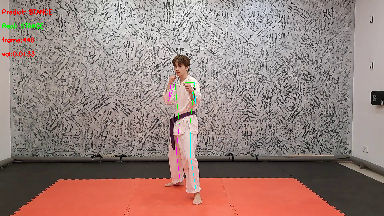

Обработано 440 кадров
Всего обработано 450 кадров


In [ ]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Андрей МАВАШИ ГЕРИ'
df_test=df[df['filename']==file_name].sort_values('frame#')
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset_alia/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
Y_test=df_test[y_column_list].values
mark_move(result,VideoPathIn,VideoPathOut,Y_test,original_df=df_test,show_landmarks=True)

##Прочее

In [ ]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Андрей МАЙ ГЕРИ КЕАГЕ (2)'
df_test=df[df['filename']==file_name].sort_values('frame#')

#Узнаем параметры для определения пути к файлу
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'
result=predict(model,df_test,x_column_list,)
Y_test=df_test[y_column_list].values
mark_move(result,VideoPathIn,VideoPathOut,Y_test,original_df=df_test,show_landmarks=True)

## Примеры из тестового датасета 2308

In [ ]:
df_2308=pd.read_csv('/content/drive/MyDrive/internship/karate/dataset_alia/CSV/dataset__test_all_features_phase.csv')
#df_2308=pd.read_csv('/content/drive/MyDrive/internship/karate/dataset/dataset__all_features_phase.csv')
#Оставим только размеченные данные
df_2308=df_2308[df_2308['phase']>0]
#Посмотрим список размеченных на данный момент ударов файлов
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df_2308['main_folder'])
print(f'Размеченные удары: {kick_list}')
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df_2308.loc[df_2308['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  #total_file_list.extend(file_list)

Размеченные удары: ['ГЕДАН БАРАЙ' 'МАВАШИ ГЕРИ' 'МАВАШИ ДЗУКИ' 'СОТО УКЕ' 'УРА МАВАШИ ГЕРИ'
 'УРАКЕН УЧИ' 'УЧИ УКЕ']
для удара ГЕДАН БАРАЙ размечены файлы ['ГЕДАН БАРАЙ_20230814_171314' 'ГЕДАН БАРАЙ_20230814_171314_flip'
 'ГЕДАН БАРАЙ_20230814_171717' 'ГЕДАН БАРАЙ_20230814_171717_flip'
 'ГЕДАН БАРАЙ_не верный замах' 'ГЕДАН БАРАЙ_не верный замах 2'
 'ГЕДАН БАРАЙ_не верный замах 2_flip'
 'ГЕДАН БАРАЙ_не верный замах_flip'] 
 Всего: 8 файлов
для удара МАВАШИ ГЕРИ размечены файлы ['МАВАШИ ГЕРИ_20230816_170111' 'МАВАШИ ГЕРИ_20230816_170111_flip'
 'МАВАШИ ГЕРИ_20230816_170212' 'МАВАШИ ГЕРИ_20230816_170212_flip'
 'МАВАШИ ГЕРИ_нет поворота на опорной ноге '
 'МАВАШИ ГЕРИ_нет поворота на опорной ноге 2'
 'МАВАШИ ГЕРИ_нет поворота на опорной ноге 2_flip'
 'МАВАШИ ГЕРИ_нет поворота на опорной ноге _flip'] 
 Всего: 8 файлов
для удара МАВАШИ ДЗУКИ размечены файлы ['МАВАШИ ДЗУКИ_20230816_165744' 'МАВАШИ ДЗУКИ_20230816_165744_flip'
 'МАВАШИ ДЗУКИ_20230816_165815' 'МАВАШИ ДЗУКИ_20230

#Сравнение главного и тестового датасета для удара Андрей ГЕДАН БАРАЙ (2)

In [ ]:
file_name='Андрей ГЕДАН БАРАЙ (2)'
frame_ratio=1
df_test=df[df['filename']==file_name].sort_values('frame#')
df_test=df_test[df_test['frame#']%frame_ratio==0]
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

#VideoPathIn=f'/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'#Для гл датасета
VideoPathOut=f'/content/{file_name} MainDataset.mp4'
result_main=predict(model,df_test,x_column_list)
Y_test=df_test[y_column_list].values
mark_move(result_main,VideoPathIn,VideoPathOut,Y_test,frame_ratio=frame_ratio,original_df=df_test,show_landmarks=True)

In [ ]:
file_name='Андрей ГЕДАН БАРАЙ (2)'
frame_ratio=1
df_test=df_2308[df_2308['filename']==file_name].sort_values('frame#')
df_test=df_test[df_test['frame#']%frame_ratio==0]
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
#VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'#Для гл датасета
VideoPathOut=f'/content/{file_name} Marked_v2_Last.mp4'
result=predict(model,df_test,x_column_list)
Y_test=df_test[y_column_list].values
mark_move(result,VideoPathIn,VideoPathOut,Y_test,frame_ratio=frame_ratio,original_df=df_test,show_landmarks=True)
print (len(result), len(Y_test))

In [ ]:
#Сравним result_main и result
comparison = result_main == result
equal_arrays = comparison.all()
print(equal_arrays)

Результаты  получились абсолютно одинаковы

In [ ]:
#сравним с эталоном
Y_test=np.argmax(df_test[y_column_list].values,axis=1)
Pred=np.argmax(result,axis=1)
comparison = Pred == Y_test
print(f'Совпадает {np.sum(comparison)/len(comparison)}% кадров')

#Расчет точности на тестовой выборке

In [ ]:
file_list=np.unique(df_2308['filename'])
for file in file_list:
  df_test=df_2308[df_2308['filename']==file].sort_values('frame#')
  #df_test=df_test[df_test['frame#']%2==0]
  Y_test=np.argmax(df_test[y_column_list].values,axis=1)
  result=np.argmax(predict(model,df_test,x_column_list),axis=1)
  print (np.unique(Y_test), np.unique(result))
  m=Accuracy()
  m.update_state(Y_test, result)
  print (f'Файл "{file}" содержит {len(df_test)} кадров. Точность предсказания: {m.result().numpy():.2f}' )




###Файл из тестового датасета

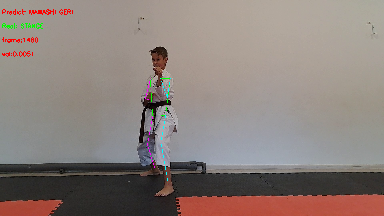

Обработано 1460 кадров
Всего обработано 1469 кадров
1469 1469


In [ ]:
full_file_name='МАВАШИ ГЕРИ_нет поворота на опорной ноге 2'
arr=full_file_name.split('_',1)
main_folder=arr[0]
file_name=arr[1]
frame_ratio=1
df_test=df_2308[(df_2308['filename']==full_file_name) ].sort_values('frame#')
df_test=df_test[df_test['frame#']%frame_ratio==0]
correct=df_test.correct.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset_alia/dataset_test/{correct}/{main_folder}/{folder}/{file_name}.mp4'

VideoPathOut=f'/content/{file_name} Marked_v2_Last.mp4'
result=predict(model,df_test,x_column_list)
Y_test=df_test[y_column_list].values
mark_move(result,VideoPathIn,VideoPathOut,Y_test,frame_ratio=frame_ratio,original_df=df_test,show_landmarks=True)
print (len(result), len(Y_test))